In [2]:
from allosaurus.app import read_recognizer
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import statistics
import re

c:\Users\dorre\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Section 1:


## Calculating Leveneshtein Distance and Percision using different audio files and different models. (Mostly used on FarsDat test files)

The following function will be used in all sections of this notebook,

In [3]:
#list1: list of expected symbols
#list2: list of output symbols (output of allosaurus)
#conf: list of confidence for output symbols (output of allosaurus when k>=2)
def levenshteinDistance(list1, list2, conf = None):
    m = len(list1)
    n = len(list2)
    d = [[i] for i in range(1, m + 1)]   # d matrix rows
    d.insert(0, list(range(0, n + 1)))   # d matrix columns
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if list1[i - 1] == list2[j - 1]: #Python compares strings and characters the same way => each list element can be a single character or a string (word)
                substitutionCost = 0
            else:
                if conf is None:
                    substitutionCost = 1
                else:
                    substitutionCost = conf[j-1]
            if conf is None:
                d[i].insert(j, min(d[i - 1][j] + 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + 1,                         #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + substitutionCost))     #substitution
            else: 
                d[i].insert(j, min(d[i - 1][j] + 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + conf[j-1],                 #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + substitutionCost))     #substitution
    return d[-1][-1]

In [12]:
l1 = ['r', 'o', 'b', 'a', 't']
l2 = ['r', 'b', 'a', 'k', 't']
co = [1,    2,   3,   4,   5]
dist = levenshteinDistance(l1, l2, co)
dist

5

Section 1:


In [5]:
#path of the audio file folder which should contain the text and wave files
#which are explained in the allosaurus fine-tune instructions.
parent_test_path = '.\\FARSDAT-parent-c100\\validate' 

test_text = parent_test_path + '\\text'
symbols = []
file_names = []
with open(test_text, encoding='utf-8') as file:
    for line in file:
        res = line.rstrip().split(' ')
        symbols.append(res[1:])

test_wave = parent_test_path + '\\wave'
with open(test_wave, encoding='utf-8') as file:
    for line in file:
        res = line.rstrip().split(' ')
        file_names.append(res[1])

In [4]:
#use files to evaluate the model
def eval_model(model_name):
    #path of the folder for the files containg the result (weighted lev distance for input audio files)
    levdis_files_path = '.\\output-files\\levdis-files3'
    
    recognizer = read_recognizer(model_name)

    #make output file which will contain the results.
    #remember to change the file name when using the same model!!!
    #here, the last part of the file name is used 
    #so we'll know which set of audio files are contained in the file.
    last_part = '-train'
    output_fd = open(os.path.join(levdis_files_path, model_name + last_part), 'w', encoding='utf-8') 

    for i in range(len(file_names)):
        phones = recognizer.recognize(file_names[i], lang_id="pes")
        if phones is None:
            continue
        phones = phones.rstrip().split()
        dist = levenshteinDistance(symbols[i], phones)
        perc = (len(symbols[i])-dist)/len(symbols[i])
        output_fd.write(file_names[i] + ' ' + str(dist) + ' ' + str(perc) + '\n')
    output_fd.close()

Use the above method to evalute a model using the files collected in 2 cells above.

In [ ]:
eval_model('8s100p20allrb')
print('8s100p20allrb done')

# eval_model('8s50p7')
# print('8s50p7 done')
# eval_model('8s50p10')
# print('8s50p10 done')
# eval_model('8s50p12')
# print('8s50p12 done')
# eval_model('8s50p14')
# print('8s50p14 done')
# eval_model('8s50p16')
# print('8s50p16 done')
# eval_model('8s50p18')
# print('8s50p18 done')
# eval_model('8s50p20')
# print('8s50p20 done')

Now we have a folder containing some text files. In these text files, we have the Leveneshtein Distance and percision of some audio files when they were predicted by a model.

In [6]:
#First, read those text files
input_files = []
for root_dir, cur_dir, files in os.walk(r'.\\output-files\\levdis-files3'):
    for fname in files:
        input_files.append(os.path.join('output-files\\levdis-files3', fname))

In [14]:
#in_files[i]: a file contaning audio file names, lev distances, and percision for a single model
#in_files: list of files each contaning the mentioned information for different models
#title: title of the figure
def draw_perc(in_files, title):
    i = 0
    plt.rcParams["figure.figsize"] = (15,5)
    all_percs = []
    for i in range(len(in_files)):
        with open(in_files[i], encoding='utf-8') as file:
            
            #list contaning on percision written in one file (percisions for different audio files predicted by the same model)
            percs = []

            for line in file: #each line is as follows: file_name distance percision
                res = line.rstrip().split(' ') #split on spaces
                percs.append(float(res[2])) #res[2]: percision

            #append the avg of all percision in a file (avg perc of a model) to the list
            all_percs.append(statistics.fmean(percs))
            i += 1
    
    epoch_numbers = [re.findall(r'\d+', val) for key,val in enumerate(in_files,1)]
    epoch_numbers = [int(col[3]) for col in epoch_numbers]   
    plt.plot(epoch_numbers,all_percs)
    plt.xticks(range(epoch_numbers[0] , epoch_numbers[len(epoch_numbers)-1]+1), range(epoch_numbers[0] , epoch_numbers[len(epoch_numbers)-1]+1))
    plt.xlabel('Epoch')
    plt.ylabel('Percision')
    plt.title(title)  
    plt.grid()     
    plt.show()

In [8]:
print(input_files)
print(len(input_files))

['output-files\\levdis-files3\\8s100p07-tests', 'output-files\\levdis-files3\\8s100p10-tests', 'output-files\\levdis-files3\\8s100p12-tests', 'output-files\\levdis-files3\\8s100p14-tests', 'output-files\\levdis-files3\\8s100p16-tests', 'output-files\\levdis-files3\\8s100p18-tests', 'output-files\\levdis-files3\\8s100p20-tests', 'output-files\\levdis-files3\\8s10p01-tests', 'output-files\\levdis-files3\\8s10p02-tests', 'output-files\\levdis-files3\\8s10p03-tests', 'output-files\\levdis-files3\\8s10p04-tests', 'output-files\\levdis-files3\\8s10p05-tests', 'output-files\\levdis-files3\\8s10p06-tests', 'output-files\\levdis-files3\\8s10p07-tests', 'output-files\\levdis-files3\\8s10p08-tests', 'output-files\\levdis-files3\\8s10p09-tests', 'output-files\\levdis-files3\\8s10p10-tests', 'output-files\\levdis-files3\\8s10p11-tests', 'output-files\\levdis-files3\\8s10p12-tests', 'output-files\\levdis-files3\\8s10p13-tests', 'output-files\\levdis-files3\\8s10p14-tests', 'output-files\\levdis-file

#### An example of the figure drawn by draw_perc:

The percision of model 8s10p with epochs 1 to 25 has been drawn as an example. This is the percision resulted from inputing the FARSDAT test files to the model.

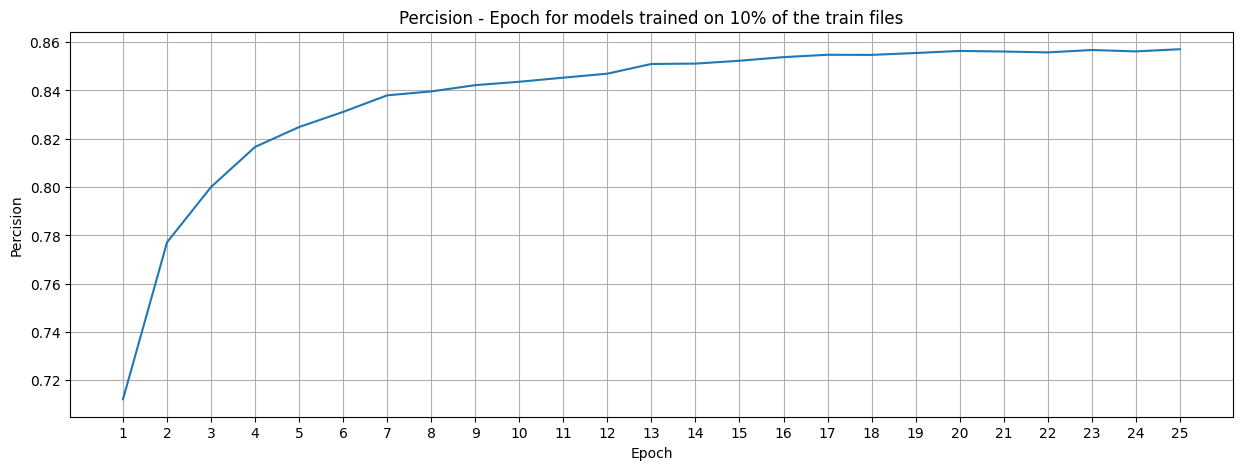

In [15]:
draw_perc(input_files[7:32], "Percision - Epoch for models trained on 10% of the train files")

# Section 2:

## Calculate and process the leveneshtein distance on robat-e-beheshti files

In [16]:
#since the initial model uses a wide range of symbols for each phone, all the possible phone arrangements need to be checked.
t_list1 = ['r', 'o', 'b', 'ɒ', 'tʰ', 'e', 'b', 'e', 'h', 'e', 'ʃ', 'tʰ', 'i']
t_list2 = ['r̪', 'o̞', 'b', 'ɒː', 't̠', 'e̞', 'b', 'e̞', 'h', 'e̞', 'ʃ', 't̠', 'i']
t_list3 = ['r̪', 'o̞', 'b', 'ɒː', 't̪ʰ', 'e', 'b', 'e', 'h', 'e', 'ʃʰ', 't̪ʰ', 'iː']

def levenshteinDistanceForBadUni(input_list, conf = None):
    m = len(input_list)
    n = len(t_list1)
    d = [[i] for i in range(1, m + 1)]   # d matrix rows
    d.insert(0, list(range(0, n + 1)))   # d matrix columns
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if input_list[i - 1] == t_list1[j - 1] or input_list[i - 1] == t_list2[j - 1] or input_list[i - 1] == t_list3[j - 1]:
                substitutionCost = 0
            else:
                if conf is None:
                    substitutionCost = 1
                else:
                    substitutionCost = conf[j-1]
            if conf is None:
                d[i].insert(j, min(d[i - 1][j] + 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + 1,                         #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + substitutionCost))     #substitution
            else: 
                d[i].insert(j, min(d[i - 1][j] + 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + conf[j-1],                 #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + substitutionCost))     #substitution
    return d[-1][-1]

In [17]:
target_phone_list = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']

def eval_model(filenames, model_name, output_file_name_extra):
    #folder where output text files will be written
    levdis_files_path = '.\\output-files\\levdis-files-allrb20-robatbeheshti'

    recognizer = read_recognizer(model_name)

    #output file for writing the results
    output_fd = open(os.path.join(levdis_files_path, model_name + output_file_name_extra), 'w', encoding='utf-8') 

    all_perc_values = []

    for i in range(len(filenames)):
        phones = recognizer.recognize(filenames[i], lang_id="pes")
        if phones is None:
            continue
        phones = phones.rstrip().split()

        dist = levenshteinDistance(target_phone_list, phones)
        # dist = levenshteinDistanceForBadUni(phones) #change to this line when model is the initial uni2005 model

        output_fd.write(filenames[i] + ' ' + str(dist) + '\n')
    output_fd.close()


#### An exaple of using the above functions for evaluating model

The model allrb20 (uni2005 with modified symbols, trained on all training files of robat-e-beheshti) has been used as an example here.

In [16]:
parent_test_path = '.\\validation-ntns' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
eval_model(f1, 'allrb20', '-ntns')
print('ntns done')


parent_test_path = '.\\validation-nts' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
eval_model(f1, 'allrb20', '-nts')
print('nts done')

parent_test_path = '.\\validation-target' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
eval_model(f1, 'allrb20', '-target')
print('target done')

ntns done
nts done
target done


### Function for drawing a histogram of the Leveneshtein Distances

In [10]:
def draw_hist(in_file, xlim, ylim, title):

    fig , ax = plt.subplots(1, 1, figsize = (20, 10))

    with open(in_file, encoding='utf-8') as file:
        dists = []
        for line in file:
            res = line.rstrip().split(' ')
            dists.append(int(res[1]))
        dists.sort()
        
        ax.title.set_text(title)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.hist(dists, bins = dists)   
         
        plt.show()

#### The rest of the example (drawing the figures)

In [17]:
input_files = []
for root_dir, cur_dir, files in os.walk(r'.\\levdis-files-allrb20-robatbeheshti'):
    for fname in files:
        input_files.append(os.path.join('levdis-files-allrb20-robatbeheshti', fname))
input_files

['levdis-files-allrb20-robatbeheshti\\allrb20-ntns',
 'levdis-files-allrb20-robatbeheshti\\allrb20-nts',
 'levdis-files-allrb20-robatbeheshti\\allrb20-target']

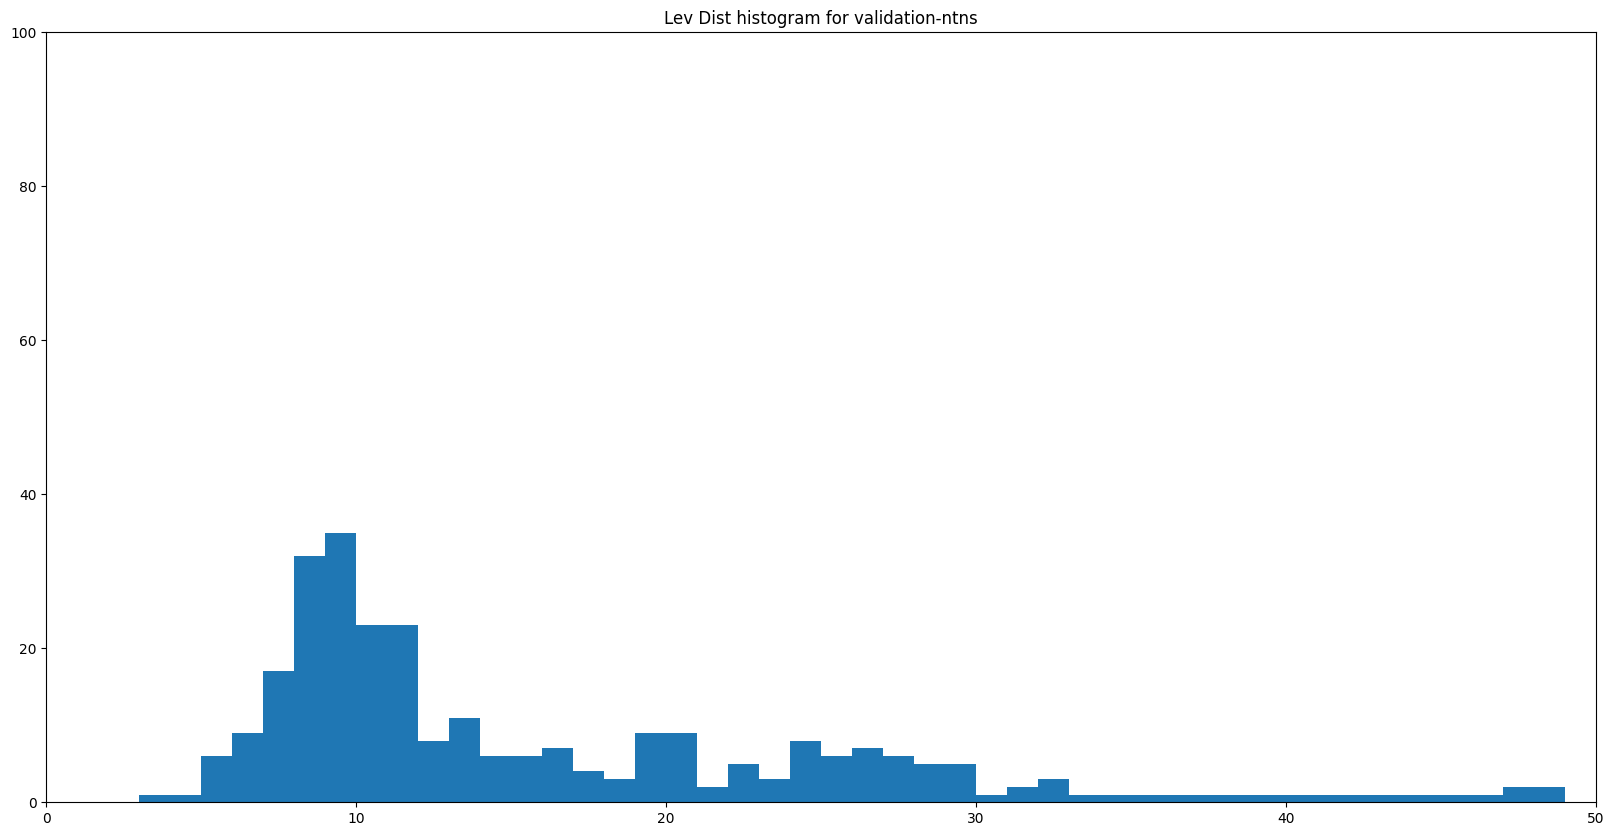

In [18]:
xlim = [0,50]
ylim = [0,100]

draw_hist(input_files[0], xlim, ylim, "Lev Dist histogram for validation-ntns")


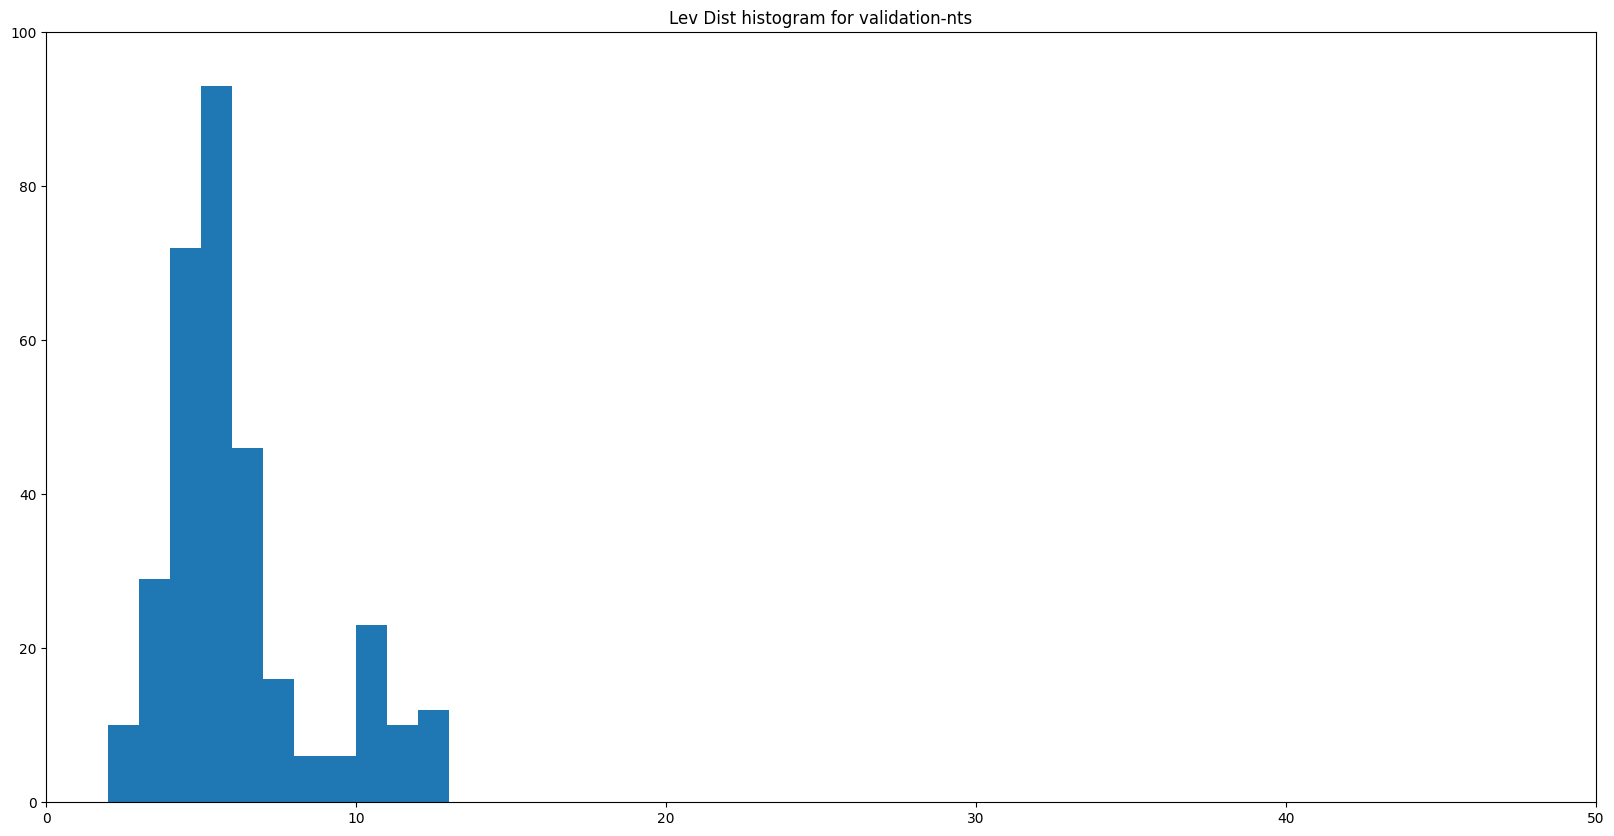

In [19]:
xlim = [0,50]
ylim = [0,100]

draw_hist(input_files[1], xlim, ylim, "Lev Dist histogram for validation-nts")

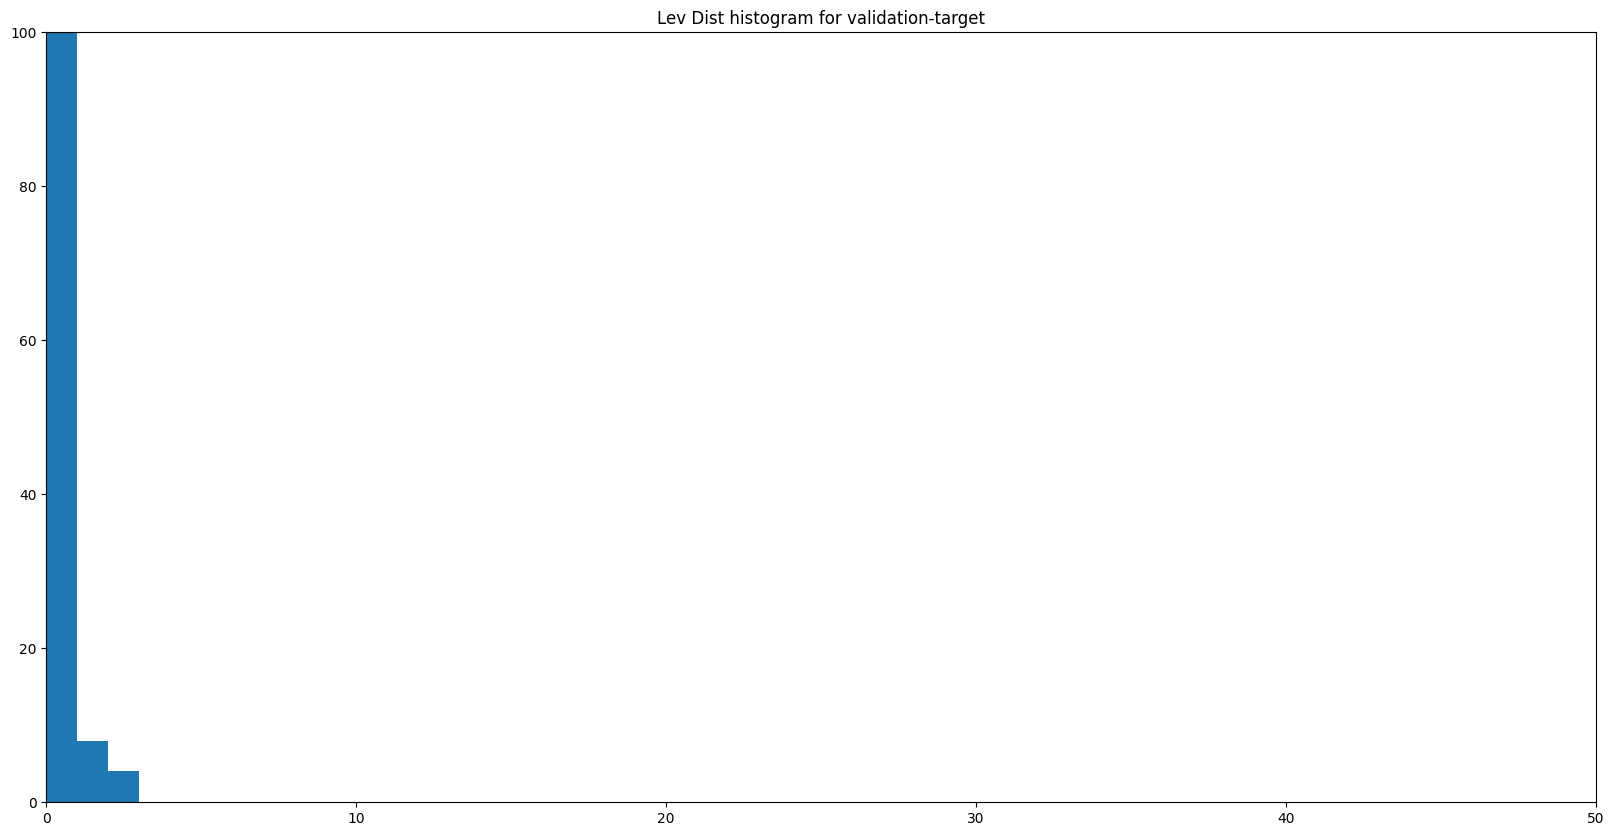

In [20]:
xlim = [0,50]
ylim = [0,100]

draw_hist(input_files[2], xlim, ylim, "Lev Dist histogram for validation-target")


### Function for calculating accuracy when a threshold is set on the leveneshtein distance of an audio file to mark it as target/non-target.

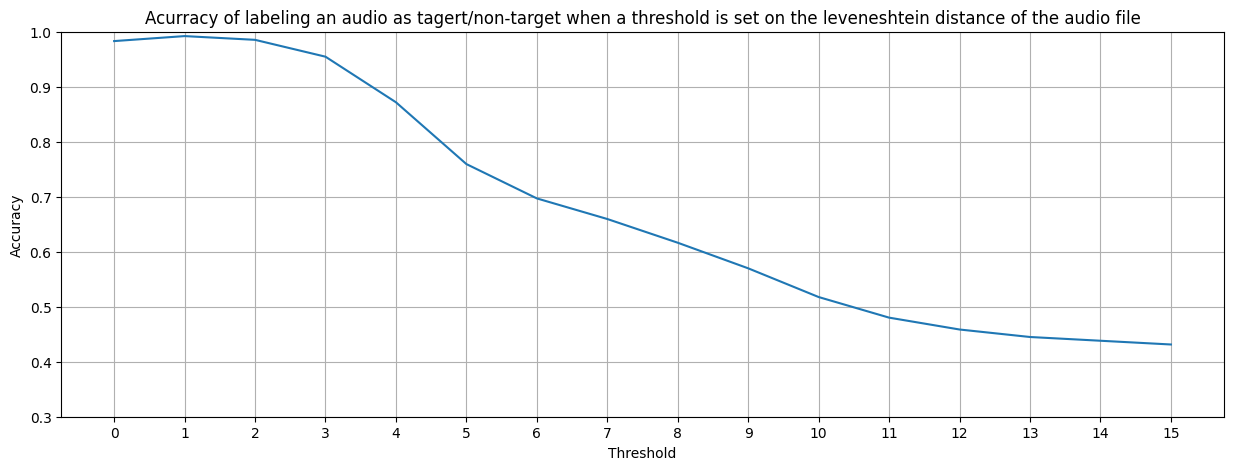

accuracy at 1:  0.9920544835414302
accuracy at 2:  0.985244040862656


In [21]:
spl_word = '.wav '
total_file = 0
acc = []
val1 = []
val2 = []
val3 = []
thresh_range = range(0,16)
with open(input_files[0], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        val1.append(int(res[1]))
with open(input_files[1], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        val2.append(int(res[1]))
with open(input_files[2], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        val3.append(int(res[1]))
     
for thresh in thresh_range:
    correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
    acc.append(correct/total_file)

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(thresh_range,acc)
plt.xticks(thresh_range, thresh_range)
plt.xlabel('Threshold')
plt.ylabel('Accuracy') 
plt.title('Acurracy of labeling an audio as tagert/non-target when a threshold is set on the leveneshtein distance of the audio file')
plt.grid()   
plt.ylim([0.30, 1.0])  
plt.show()

print("accuracy at 1: ", acc[1])
print("accuracy at 2: ", acc[2])

Output the name of the files which were a false positive on the most accurate threshold

In [ ]:
accurate_thresh = 1
with open(input_files[0], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        if int(res[1]) <= accurate_thresh:
            print(res[0])
with open(input_files[1], encoding='utf-8') as file:
    for line in file:
        total_file += 1
        res = line.rstrip().split(spl_word, 1)
        if int(res[1]) <= accurate_thresh:
            print(res[0])

# Section 3

## Using topk and confidence for calculating the levenshtein distance

In [ ]:
#get leveneshtein distance for input files using the input model and k=2
#in order to obtain the confidence for each produced phone in the output.
def get_levdist_with_k(model_name, filenames, actual_symbols):
    #path of the folder for the files containg the result (weighted lev distance for input audio files)
    levdis_files_path = '.\\output-files\\levdis-files-with-k'

    recognizer = read_recognizer(model_name)

    #make output file which will contain the results
    output_fd = open(os.path.join(levdis_files_path, model_name + '-validate'), 'w', encoding='utf-8') 

    all_perc_values = []

    for i in range(len(filenames)):
        rec_out = recognizer.recognize(filenames[i], lang_id="pes", topk=2)
        if rec_out is None:
            continue
        #an example of an output (rec_out): 'r (0.871) l (0.121) | m (0.771) n (0.031) | ...'
        rec_out = rec_out.rstrip().split() #split on spaces

        #only the top phone is needed so for the above example we need 'r', 'm', ...
        phones = rec_out[::5]
        
        #only the top confidence is needed so for the above example we need '(0.871)', '(0.771)', ...
        #but we need the float numbers and not the strings so parentheses should be removed first and then the number be converted to float
        confidence = [float(re.sub(r'[()]', '', val)) for key,val in enumerate(rec_out) if key % 5 == 1] 

        dist = levenshteinDistance(actual_symbols[i], phones, confidence) #weighted lev distance
        perc = (len(actual_symbols[i])-dist)/len(actual_symbols[i]) #percision ()

        output_fd.write(filenames[i] + ' ' + str(dist) + ' ' + str(perc) + '\n')

    output_fd.close()